In [2]:
from keras.models import load_model
import cv2
import time
import numpy as np
import os
import csv
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



In [6]:

# CSV file and headers
time_csv = 'time.csv'
headers = ['crop_time', 'read_image_time', 'model_time', 'full_time', 'run_time']

# Create CSV file with headers if not exists
if not os.path.exists(time_csv):
    with open(time_csv, mode='w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(headers)

# Initialize video capture (0 for default webcam)
cap = cv2.VideoCapture(0)

# Variables for FPS calculation
t_prev = 0

def crop_center(img, crop_w=40, crop_h=480):
    h, w = img.shape[:2]
    x0 = max((w - crop_w) // 2, 0)
    y0 = max((h - crop_h) // 2, 0)
    return img[y0:y0 + crop_h, x0:x0 + crop_w]

while True:
    # Start full loop timer
    t_full_start = time.perf_counter()

    # Read image and measure time
    t_read_start = time.perf_counter()
    ret, frame = cap.read()
    t_read = (time.perf_counter() - t_read_start) * 1_000_000  # microseconds
    if not ret:
        break

    # Crop and measure time
    t_crop_start = time.perf_counter()
    cropped = crop_center(frame)
    t_crop = (time.perf_counter() - t_crop_start) * 1_000_000  # microseconds

    # Model inference placeholder and measure time
    t_model_start = time.perf_counter()
    # e.g., pred = model.predict(preprocess(cropped))
    t_model = (time.perf_counter() - t_model_start) * 1_000_000  # microseconds

    # End full loop timer
    t_full = (time.perf_counter() - t_full_start) * 1_000_000  # microseconds

    # Calculate run time (e.g., time excluding reading)
    run_time = t_crop + t_model + (t_full - (t_crop + t_model + t_read))

    # Append timing data to CSV
    with open(time_csv, mode='a', newline='') as f:
        writer = csv.writer(f)
        writer.writerow([
            f"{t_crop:.2f}",
            f"{t_read:.2f}",
            f"{t_model:.2f}",
            f"{t_full:.2f}",
            f"{run_time:.2f}"
        ])

    # Calculate FPS
    t_curr = time.time()
    fps = 1 / (t_curr - t_prev) if t_prev else 0
    t_prev = t_curr

    # Overlay FPS on the frame
    fps_text = f"FPS: {fps:.2f}"
    cv2.putText(frame, fps_text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX,
                1, (0, 255, 0), 2, cv2.LINE_AA)

    # Draw central rectangle of size 40x480 (width x height)
    h, w = frame.shape[:2]
    rect_w, rect_h = 40, h
    top_left = ((w - rect_w) // 2, 0)
    bottom_right = ((w + rect_w) // 2, h)
    cv2.rectangle(frame, top_left, bottom_right, (255, 0, 0), 2)

    # Display the resulting frame
    cv2.imshow('Webcam with FPS, Rectangle, and Timing CSV', frame)

    # Exit on 'q' key press
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Cleanup
cap.release()
cv2.destroyAllWindows()


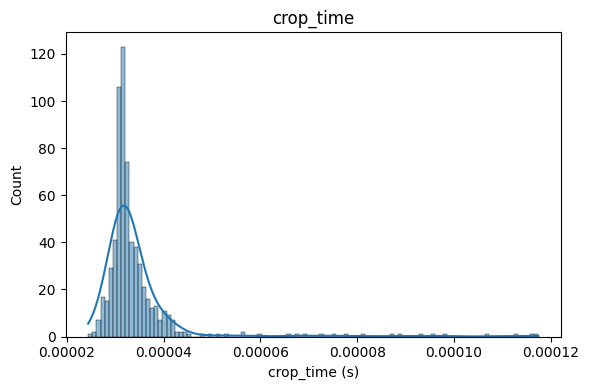

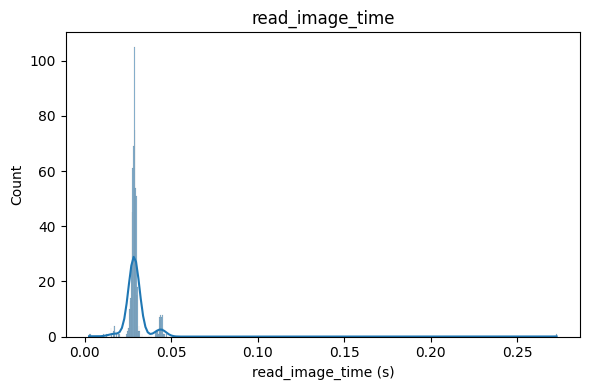

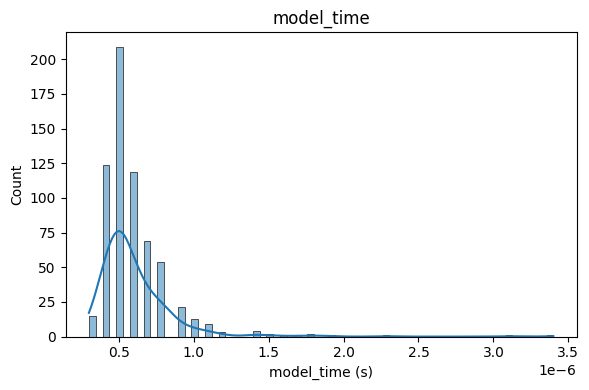

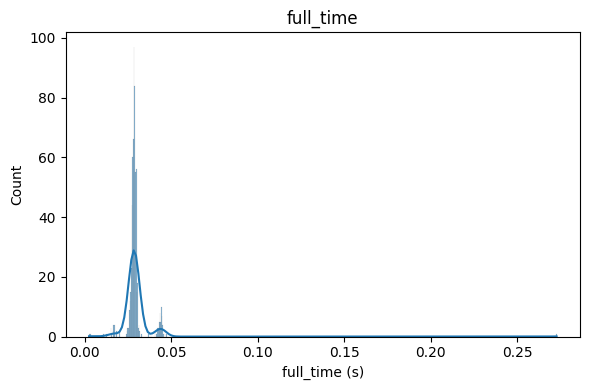

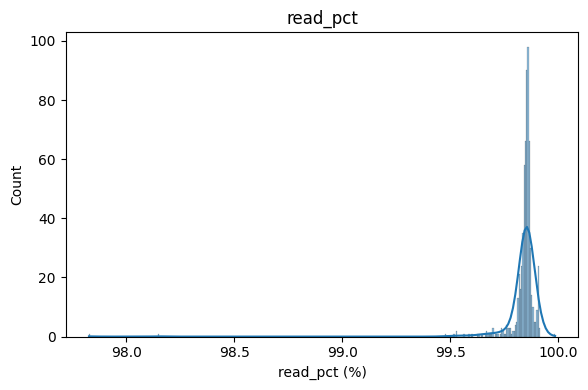

In [5]:
# 1. Load the data
df = pd.read_csv('time.csv')

# 2. Convert from microseconds to seconds for the first four columns
cols_us = ['crop_time', 'read_image_time', 'model_time', 'full_time']
df[cols_us] = df[cols_us] / 1_000_000

# 3. (Optional) If you want read_image_time as a percentage of full_time:
#    e.g. how much of the loop is spent reading the image
df['read_pct'] = df['read_image_time'] / df['full_time'] * 100

# 4. Plot each distribution once:
for col in cols_us + ['read_pct']:
    plt.figure(figsize=(6,4))
    sns.histplot(df[col], kde=True)
    plt.title(col)
    plt.xlabel(f"{col} ({'s' if col in cols_us else '%'})")
    plt.tight_layout()
    plt.show()


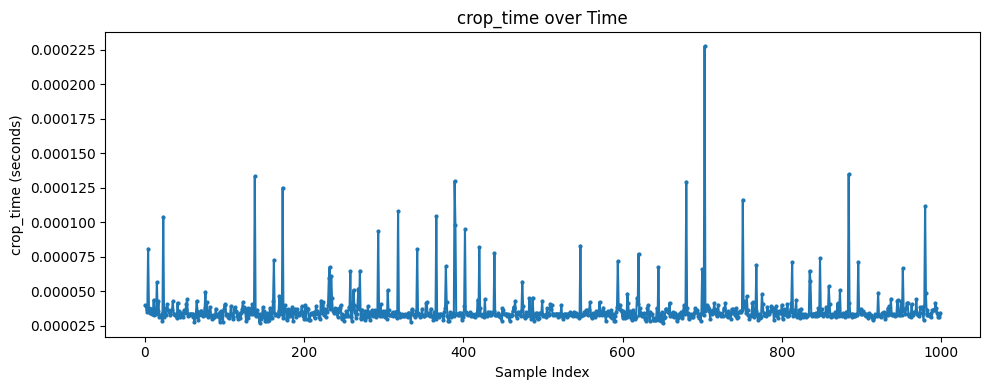

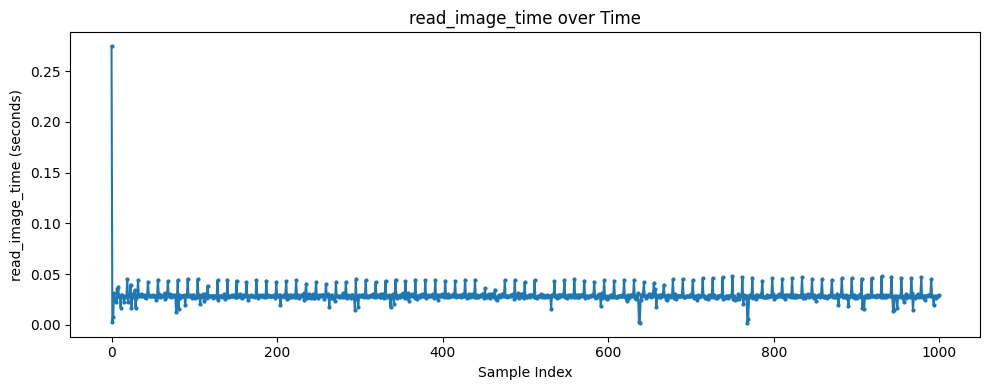

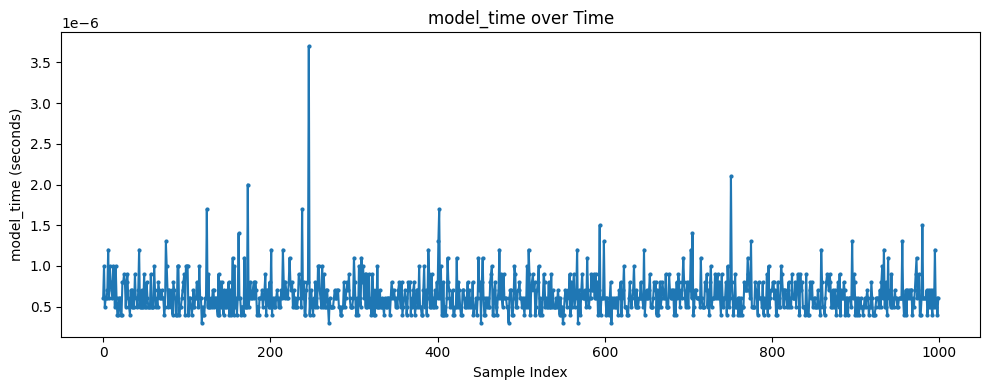

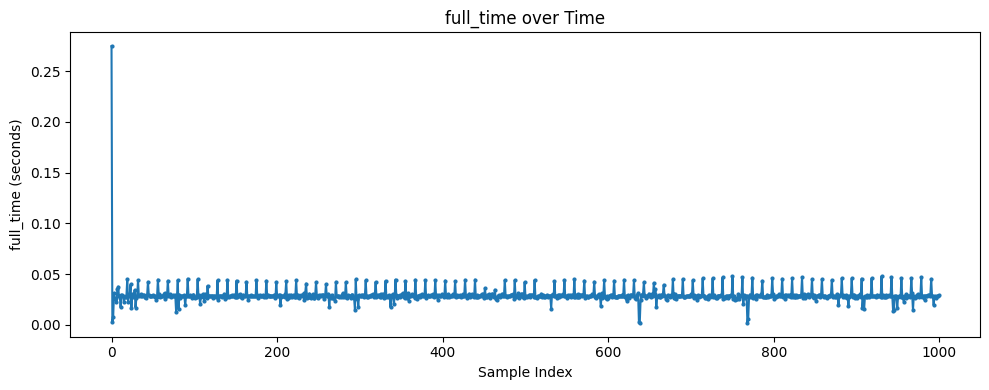

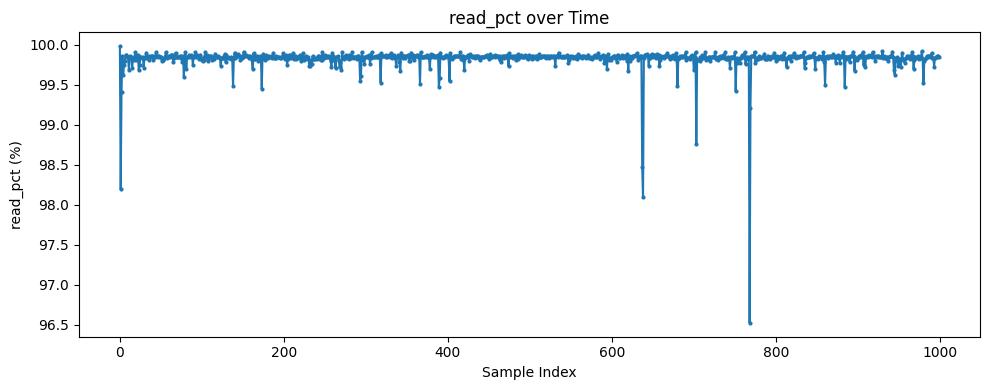

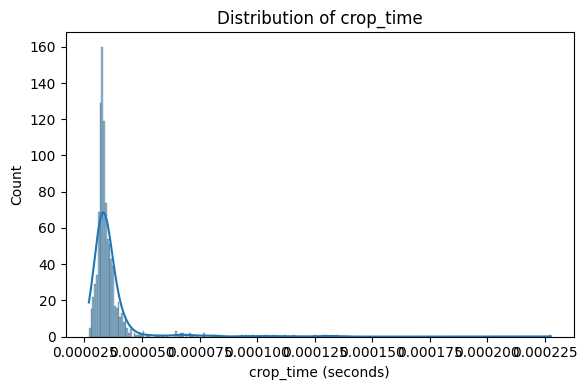

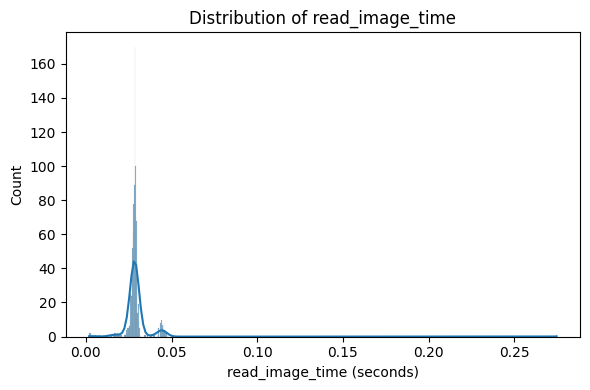

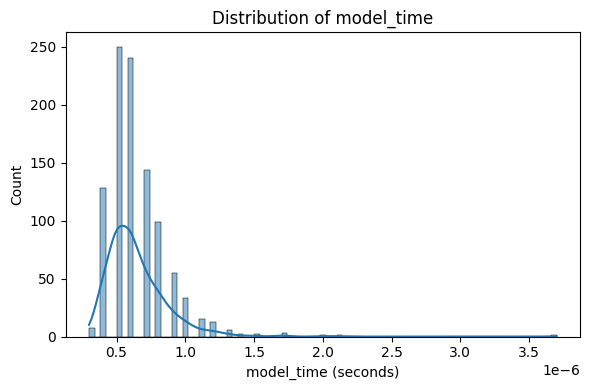

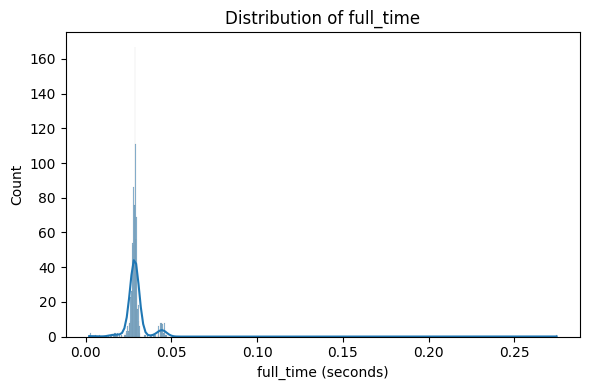

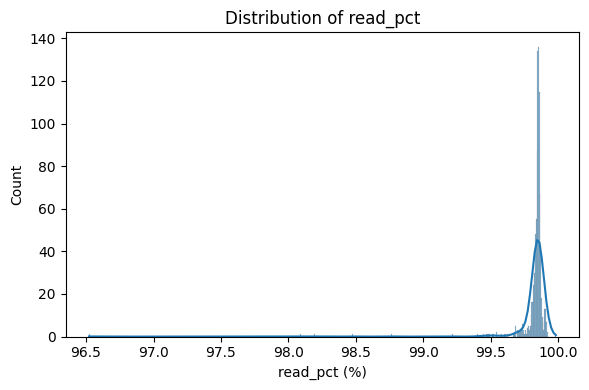

In [7]:
# 1. Load the data, parsing the "timestamp" column as datetime if present
#    If your CSV has a timestamp column, use parse_dates; otherwise create one from the index
def load_time_data(csv_path='time.csv'):
    try:
        df = pd.read_csv(csv_path, parse_dates=['timestamp'])
        df.set_index('timestamp', inplace=True)
    except (ValueError, KeyError):
        df = pd.read_csv(csv_path)
        # If no timestamp column, use simple integer index or convert index to datetime if meaningful
        df.index = pd.RangeIndex(len(df))
    return df

# 2. Preprocess timings
def preprocess_timings(df):
    timing_cols = ['crop_time', 'read_image_time', 'model_time', 'full_time']
    # Convert from microseconds to seconds
    df[timing_cols] = df[timing_cols] / 1_000_000
    # Add percentage column
    if 'read_image_time' in df and 'full_time' in df:
        df['read_pct'] = df['read_image_time'] / df['full_time'] * 100
    return df, timing_cols

# 3. Plot time series for each metric
def plot_time_series(df, timing_cols):
    for col in timing_cols + ['read_pct']:
        if col not in df:
            continue
        plt.figure(figsize=(10, 4))
        plt.plot(df.index, df[col], marker='o', linestyle='-', markersize=2)
        plt.title(f"{col} over Time")
        plt.xlabel('Sample Index' if not isinstance(df.index, pd.DatetimeIndex) else 'Time')
        plt.ylabel(f"{col} ({'seconds' if col in timing_cols else '%'})")
        plt.tight_layout()
        plt.show()

# 4. Plot distribution for each metric once
def plot_distributions(df, timing_cols):
    for col in timing_cols + ['read_pct']:
        if col not in df:
            continue
        plt.figure(figsize=(6, 4))
        sns.histplot(df[col], kde=True)
        plt.title(f"Distribution of {col}")
        plt.xlabel(f"{col} ({'seconds' if col in timing_cols else '%'})")
        plt.tight_layout()
        plt.show()

# Main execution
if __name__ == '__main__':
    # Load and preprocess
    df = load_time_data('time.csv')
    df, timing_cols = preprocess_timings(df)

    # Plot time series
    plot_time_series(df, timing_cols)

    # Plot distributions once
    plot_distributions(df, timing_cols)

1/1 [==============================] - 0s 46ms/step
Wrote test_acc.csv with 6576 rows.
1/1 [==============================] - 0s 257ms/step
Wrote test_acc+n.csv with 6576 rows.
-0.34630607976433303
5.399710255398544


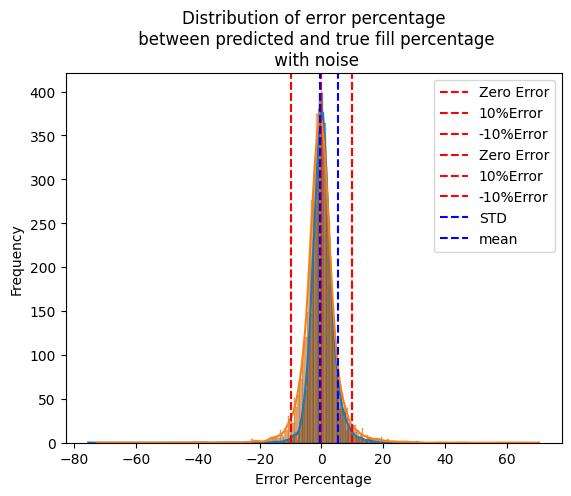

In [4]:
import os
import csv
import numpy as np
import cv2
from tensorflow import keras
import pandas as pd

# --- Your existing helper ---
def preprocess_image(img_path, img_size):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"Image not found or invalid path: {img_path}")
    img = cv2.resize(img, (img_size[1], img_size[0]))
    img = img / 255.0
    img_array = np.expand_dims(img, axis=-1)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# --- Load your trained model ---
model = keras.models.load_model("BFP02D2x4s40N2T035.h5")

# --- Read labels ---
labels_df = pd.read_csv("cop_img_dataset1/labels.csv")  # expects columns: filename, fill_percentage

# Prepare output records
output_rows = []

for idx, row in labels_df.iterrows():
    fname = row["filename"]
    true_fill = float(row["fill_percentage"])
    img_path = os.path.join("cop_img_dataset1", fname)  # adjust folder if needed

    try:
        # Preprocess and predict
        img_array = preprocess_image(img_path, (100, 100))
        pred_fill = float(model.predict(img_array)[0][0])  # between 0 and 1?

        # Compute signed error in percentage
        error_pct = (pred_fill - true_fill) * 100

        output_rows.append({
            "filename": fname,
            "predicted_fill": pred_fill,
            "true_fill": true_fill,
            "error_percentage": error_pct
        })

    except Exception as e:
        print(f"Skipping {fname}: {e}")

# --- Write results ---
output_df = pd.DataFrame(output_rows,
                         columns=["filename", "predicted_fill", "true_fill", "error_percentage"])
output_df.to_csv("test_acc.csv", index=False)
print("Wrote test_acc.csv with", len(output_rows), "rows.")

import seaborn as sns
import matplotlib.pyplot as plt
# Load the data
df = pd.read_csv('test_acc.csv')
data=df.iloc[:, 3] 
# Convert fill_percentage to temperature
sns.histplot(data, kde=True)
plt.title('Distribution of error percentage\n between predicted and true fill percentage\n no noise')
plt.xlabel('Error Percentage')
plt.ylabel('Frequency')
plt.axvline(x=0, color='r', linestyle='--', label='Zero Error')
plt.axvline(x=10, color='r', linestyle='--', label='10%'+"Error" )
plt.axvline(x=-10, color='r', linestyle='--', label="-10%"+"Error")
plt.legend()
plt.grid()


import random as ra
from skimage.util import random_noise

noise_modes = ['s&p', 'pepper', 'salt', 'gaussian']
# --- Your existing helper ---
def preprocess_image(img_path, img_size):
    noise_type = ra.randint(0, len(noise_modes) - 1)
    mode = noise_modes[noise_type]

    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"Image not found or invalid path: {img_path}")
    
    img = cv2.resize(img, (img_size[1], img_size[0]))
    img = img.astype(np.float32) / 255.0  # normalize before adding noise

    # Apply noise
    if mode in ['salt', 'pepper', 's&p']:
        img = random_noise(img, mode=mode, amount=0.05)
    elif mode == 'gaussian':
        img = random_noise(img, mode=mode, var=0.001)

    img_array = np.expand_dims(img, axis=-1)
    img_array = np.expand_dims(img_array, axis=0)

    return img_array

# --- Load your trained model ---
# model = keras.models.load_model("BFP02D2x4s40N2T035.h5")

# --- Read labels ---
# labels_df = pd.read_csv("cop_img_dataset1/labels.csv")  # expects columns: filename, fill_percentage

# Prepare output records
output_rows = []

for idx, row in labels_df.iterrows():
    fname = row["filename"]
    true_fill = float(row["fill_percentage"])
    img_path = os.path.join("cop_img_dataset1", fname)  # adjust folder if needed

    try:
        # Preprocess and predict
        img_array = preprocess_image(img_path, (100, 100))
        pred_fill = float(model.predict(img_array)[0][0])  # between 0 and 1?

        # Compute signed error in percentage
        error_pct = (pred_fill - true_fill) * 100

        output_rows.append({
            "filename": fname,
            "predicted_fill": pred_fill,
            "true_fill": true_fill,
            "error_percentage": error_pct
        })

    except Exception as e:
        print(f"Skipping {fname}: {e}")

# --- Write results ---
output_df = pd.DataFrame(output_rows,
                         columns=["filename", "predicted_fill", "true_fill", "error_percentage"])
output_df.to_csv("test_acc+n.csv", index=False)
print("Wrote test_acc+n.csv with", len(output_rows), "rows.")

# Load the data
df = pd.read_csv('test_acc+n.csv')
data=df.iloc[:, 3] 
print (data.mean())
print (data.std())
# Convert fill_percentage to temperature
sns.histplot(data, kde=True)
plt.title('Distribution of error percentage\n between predicted and true fill percentage\n with noise')
plt.xlabel('Error Percentage')
plt.ylabel('Frequency')
plt.axvline(x=0, color='r', linestyle='--', label='Zero Error')
plt.axvline(x=10, color='r', linestyle='--', label='10%'+"Error" )
plt.axvline(x=-10, color='r', linestyle='--', label="-10%"+"Error")
plt.axvline(x=data.std(), color='b',linestyle='--',  label="STD")
plt.axvline(x=data.mean(), color='b',linestyle='--', label="mean")
plt.legend()
plt.grid()

plt.show()



0.34627438897362006


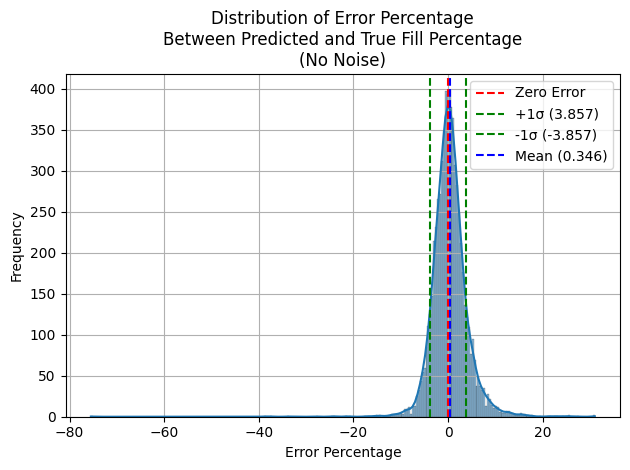

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the data
df = pd.read_csv('test_acc.csv')
data = df.iloc[:, 3]  # Assuming the 4th column is the error percentage

# Calculate stats
std_value = round(data.std(), 3)
mean_value = round(data.mean(), 3)
print (data.mean())
# Plot histogram with KDE
sns.histplot(data, kde=True)
plt.title('Distribution of Error Percentage\nBetween Predicted and True Fill Percentage\n(No Noise)')
plt.xlabel('Error Percentage')
plt.ylabel('Frequency')

# Vertical lines
plt.axvline(x=0, color='r', linestyle='--', label='Zero Error')
plt.axvline(x=std_value, color='g', linestyle='--', label=f'+1σ ({std_value})')
plt.axvline(x=-std_value, color='g', linestyle='--', label=f'-1σ ({-std_value})')
plt.axvline(x=mean_value, color='b', linestyle='--', label=f'Mean ({mean_value})')

# Add legend and grid
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()


-0.34630607976433303


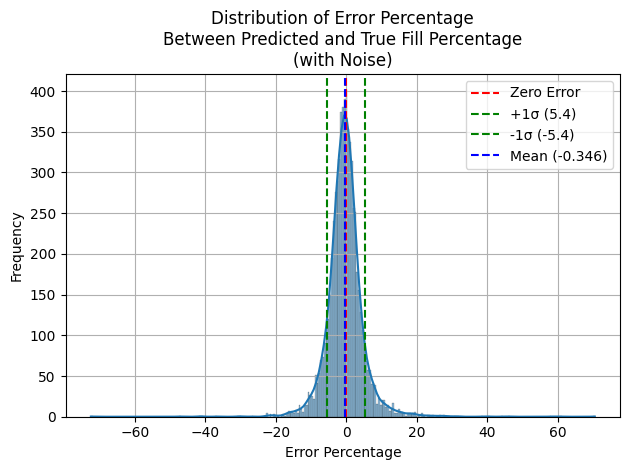

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the data
df = pd.read_csv('test_acc+n.csv')
data = df.iloc[:, 3]  # Assuming the 4th column is the error percentage

# Calculate stats
std_value = round(data.std(), 3)
mean_value = round(data.mean(), 3)
print (data.mean())
# Plot histogram with KDE
sns.histplot(data, kde=True)
plt.title('Distribution of Error Percentage\nBetween Predicted and True Fill Percentage\n(with Noise)')
plt.xlabel('Error Percentage')
plt.ylabel('Frequency')

# Vertical lines
plt.axvline(x=0, color='r', linestyle='--', label='Zero Error')
plt.axvline(x=std_value, color='g', linestyle='--', label=f'+1σ ({std_value})')
plt.axvline(x=-std_value, color='g', linestyle='--', label=f'-1σ ({-std_value})')
plt.axvline(x=mean_value, color='b', linestyle='--', label=f'Mean ({mean_value})')

# Add legend and grid
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()

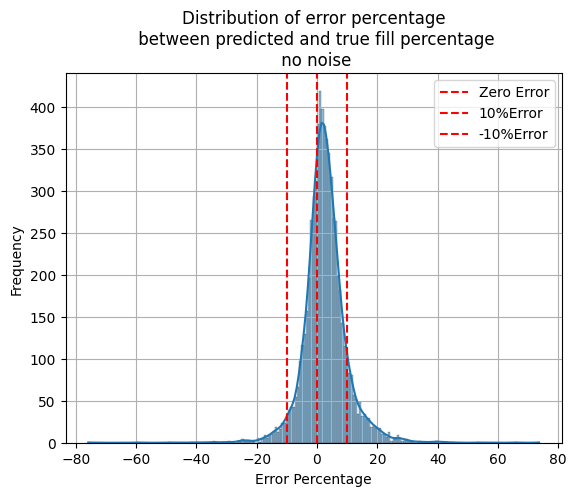

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
# Load the data
df = pd.read_csv('test_acc.csv')
data=df.iloc[:, 3] 
# Convert fill_percentage to temperature
sns.histplot(data, kde=True)
plt.title('Distribution of error percentage\n between predicted and true fill percentage\n no noise')
plt.xlabel('Error Percentage')
plt.ylabel('Frequency')
plt.axvline(x=0, color='r', linestyle='--', label='Zero Error')
plt.axvline(x=round(data.std(), 3), color='g', linestyle='--', label=f"std{round(data.std(), 3)}" )
plt.axvline(x=-round(data.std(), 3), color='g', linestyle='--', label=f"-std{round(data.std(), 3)}")
plt.axvline(x=-data.mean(), color='g', linestyle='--', label=f"the mean {data.mean()}")
plt.legend()
plt.grid()

plt.show()

In [10]:

import random as ra
from skimage.util import random_noise

noise_modes = ['s&p', 'pepper', 'salt', 'gaussian']
# --- Your existing helper ---
def preprocess_image(img_path, img_size):
    noise_type = ra.randint(0, len(noise_modes) - 1)
    mode = noise_modes[noise_type]

    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"Image not found or invalid path: {img_path}")
    
    img = cv2.resize(img, (img_size[1], img_size[0]))
    img = img.astype(np.float32) / 255.0  # normalize before adding noise

    # Apply noise
    if mode in ['salt', 'pepper', 's&p']:
        img = random_noise(img, mode=mode, amount=0.05)
    elif mode == 'gaussian':
        img = random_noise(img, mode=mode, var=0.001)

    img_array = np.expand_dims(img, axis=-1)
    img_array = np.expand_dims(img_array, axis=0)

    return img_array

# --- Load your trained model ---
model = keras.models.load_model("BFP02D2s40NT035.h5")

# --- Read labels ---
labels_df = pd.read_csv("cop_img_dataset1/labels.csv")  # expects columns: filename, fill_percentage

# Prepare output records
output_rows = []

for idx, row in labels_df.iterrows():
    fname = row["filename"]
    true_fill = float(row["fill_percentage"])
    img_path = os.path.join("cop_img_dataset1", fname)  # adjust folder if needed

    try:
        # Preprocess and predict
        img_array = preprocess_image(img_path, (100, 100))
        pred_fill = float(model.predict(img_array)[0][0])  # between 0 and 1?

        # Compute signed error in percentage
        error_pct = (pred_fill - true_fill) * 100

        output_rows.append({
            "filename": fname,
            "predicted_fill": pred_fill,
            "true_fill": true_fill,
            "error_percentage": error_pct
        })

    except Exception as e:
        print(f"Skipping {fname}: {e}")

# --- Write results ---
output_df = pd.DataFrame(output_rows,
                         columns=["filename", "predicted_fill", "true_fill", "error_percentage"])
output_df.to_csv("test_acc+n.csv", index=False)
print("Wrote test_acc+n.csv with", len(output_rows), "rows.")


1/1 [==============================] - 0s 47ms/step
Wrote test_acc+n.csv with 6576 rows.


-1.928316228528454
10.64453779211604


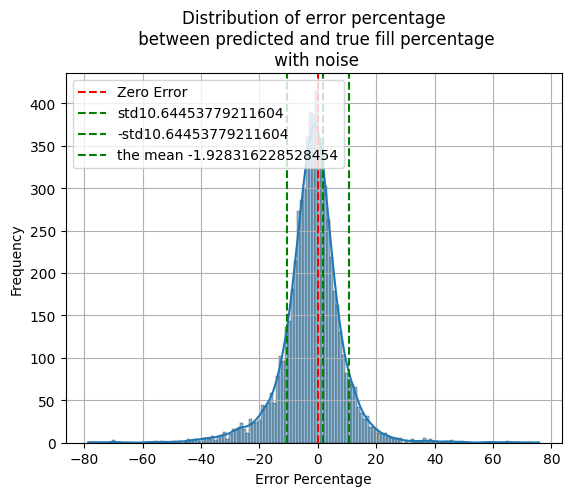

In [4]:
# Load the data
df = pd.read_csv('test_acc+n.csv')
data=df.iloc[:, 3] 
print (data.mean())
print (data.std())
# Convert fill_percentage to temperature
sns.histplot(data, kde=True)
plt.title('Distribution of error percentage\n between predicted and true fill percentage\n with noise')
plt.xlabel('Error Percentage')
plt.ylabel('Frequency')
plt.axvline(x=0, color='r', linestyle='--', label='Zero Error')
plt.axvline(x=data.std(), color='g', linestyle='--', label=f"std{data.std()}" )
plt.axvline(x=-data.std(), color='g', linestyle='--', label=f"-std{data.std()}")
plt.axvline(x=-data.mean(), color='g', linestyle='--', label=f"the mean {data.mean()}")
plt.legend()
plt.grid()

plt.show()

1/1 [==============================] - 0s 56ms/step
Wrote test_acc.csv with 6576 rows.
Normality test p-value: 1.910865764566189e-245
0.9352798684433353
13.812373377405429


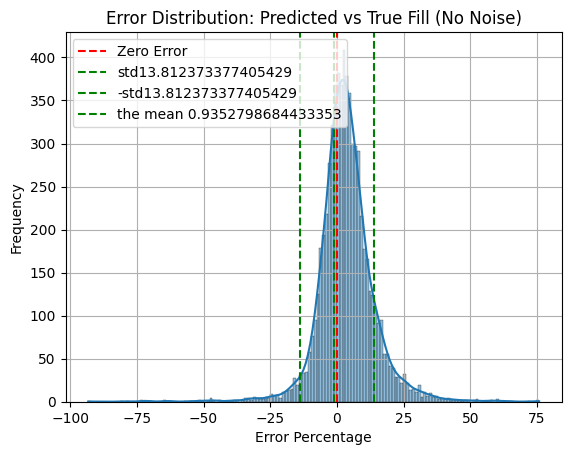

1/1 [==============================] - 0s 62ms/step
Wrote test_acc+n.csv with 6576 rows.
Normality test p-value: 4.727117601545601e-163
2.5543866133368094
14.490615017355612
Mean Error: 2.55%
Standard Deviation: 14.49%


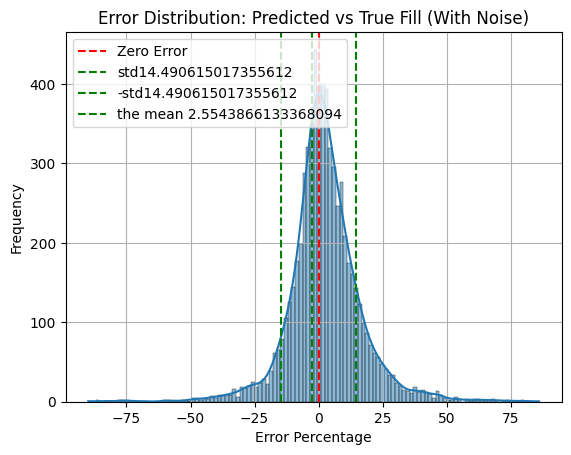

In [11]:
import os
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow import keras
from skimage.util import random_noise
import random as ra

# -------------------- CONFIG --------------------
IMG_SIZE = (100, 100)
MODEL_PATH = "BFP02D2s40N2T035x2g.h5"
LABELS_CSV = "cop_img_dataset1/labels.csv"
IMG_DIR = "cop_img_dataset1"
NOISE_MODES = ['s&p', 'pepper', 'salt', 'gaussian']

# -------------------- FUNCTIONS --------------------
def preprocess_image(img_path, img_size=IMG_SIZE, add_noise=False):
    """Load, resize, normalize and optionally add noise to the image."""
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"Image not found or invalid path: {img_path}")
    
    img = cv2.resize(img, (img_size[1], img_size[0]))
    img = img.astype(np.float32) / 255.0  # Normalize

    if add_noise:
        mode = NOISE_MODES[ra.randint(0, len(NOISE_MODES) - 1)]
        if mode in ['salt', 'pepper', 's&p']:
            img = random_noise(img, mode=mode, amount=0.05)
        elif mode == 'gaussian':
            img = random_noise(img, mode=mode, var=0.001)

    img_array = np.expand_dims(img, axis=(0, -1))
    return img_array

def evaluate_model(model, labels_df, output_csv, add_noise=False):
    """Evaluate the model and save predictions with errors to a CSV."""
    output_rows = []

    for _, row in labels_df.iterrows():
        fname = row["filename"]
        true_fill = float(row["fill_percentage"])
        img_path = os.path.join(IMG_DIR, fname)

        try:
            img_array = preprocess_image(img_path, IMG_SIZE, add_noise)
            pred_fill = float(model.predict(img_array)[0][0])
            error_pct = (pred_fill - true_fill) * 100

            output_rows.append({
                "filename": fname,
                "predicted_fill": pred_fill,
                "true_fill": true_fill,
                "error_percentage": error_pct
            })
        except Exception as e:
            print(f"Skipping {fname}: {e}")

    output_df = pd.DataFrame(output_rows)
    output_df.to_csv(output_csv, index=False)
    print(f"Wrote {output_csv} with {len(output_rows)} rows.")
    return output_df

def plot_error_distribution(df, title, with_stats=False):
    """Plot histogram of error percentage with optional stats."""
    errors = df["error_percentage"]
    sns.histplot(errors, kde=True)
    from scipy.stats import normaltest
    stat, p = normaltest(errors)
    print(f"Normality test p-value: {p}")

    plt.title(title)
    plt.xlabel("Error Percentage")
    plt.ylabel("Frequency")
    plt.axvline(x=0, color='r', linestyle='--', label='Zero Error')
    # Load the data
    df = pd.read_csv('test_acc+n.csv')
    data=df.iloc[:, 3] 
    print (data.mean())
    print (data.std())
    plt.axvline(x=data.std(), color='g', linestyle='--', label=f"std{data.std()}" )
    plt.axvline(x=-data.std(), color='g', linestyle='--', label=f"-std{data.std()}")
    plt.axvline(x=-data.mean(), color='g', linestyle='--', label=f"the mean {data.mean()}")


    if with_stats:
        mean = errors.mean()
        std = errors.std()
        print(f"Mean Error: {mean:.2f}%")
        print(f"Standard Deviation: {std:.2f}%")
    plt.legend()
    plt.grid()
    plt.show()

# -------------------- MAIN --------------------

if __name__ == "__main__":
    model = keras.models.load_model(MODEL_PATH)
    labels_df = pd.read_csv(LABELS_CSV)

    # Run evaluation on clean images
    clean_df = evaluate_model(model, labels_df, "test_acc.csv", add_noise=False)
    plot_error_distribution(clean_df, "Error Distribution: Predicted vs True Fill (No Noise)")

    # Run evaluation with noise
    noisy_df = evaluate_model(model, labels_df, "test_acc+n.csv", add_noise=True)
    plot_error_distribution(noisy_df, "Error Distribution: Predicted vs True Fill (With Noise)", with_stats=True)


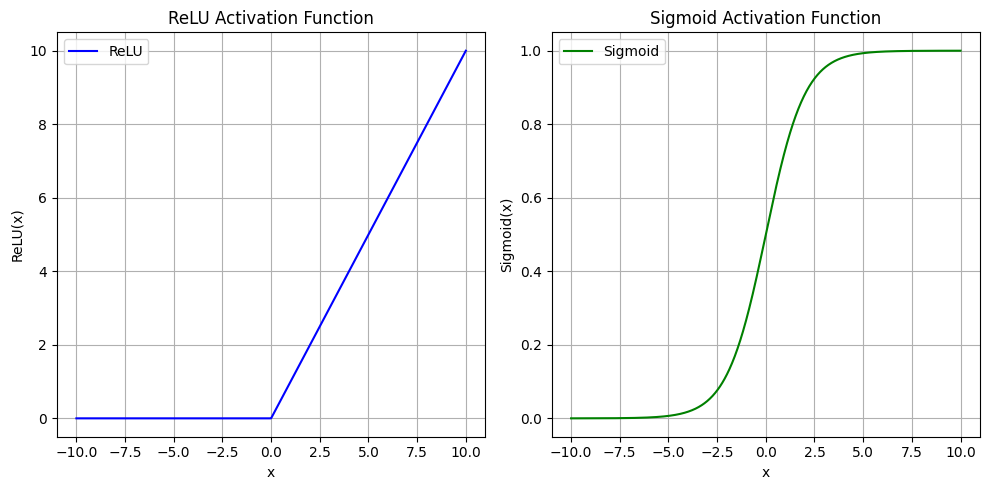

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Input range
x = np.linspace(-10, 10, 1000)

# ReLU function
relu = np.maximum(0, x)

# Sigmoid function
sigmoid = 1 / (1 + np.exp(-x))

# Plotting
plt.figure(figsize=(10, 5))

# ReLU Plot
plt.subplot(1, 2, 1)
plt.plot(x, relu, label='ReLU', color='blue')
plt.title('ReLU Activation Function')
plt.xlabel('x')
plt.ylabel('ReLU(x)')
plt.grid(True)
plt.legend()

# Sigmoid Plot
plt.subplot(1, 2, 2)
plt.plot(x, sigmoid, label='Sigmoid', color='green')
plt.title('Sigmoid Activation Function')
plt.xlabel('x')
plt.ylabel('Sigmoid(x)')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


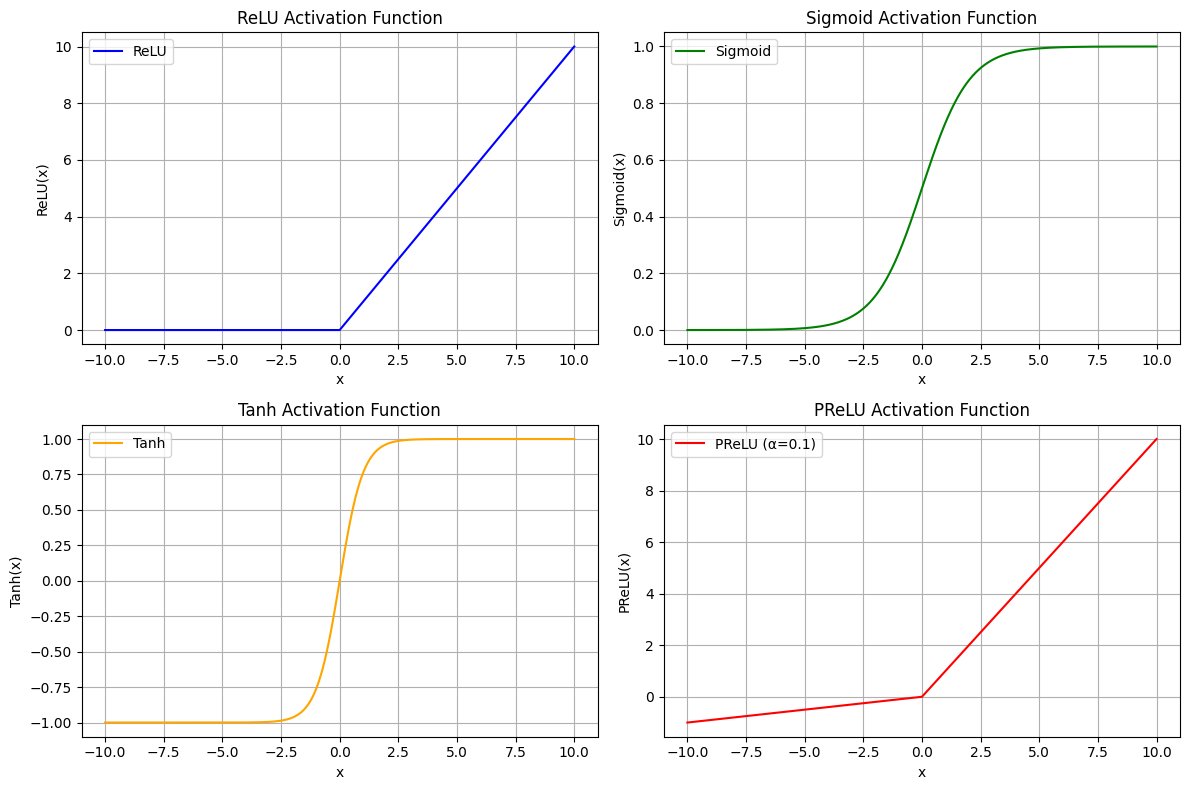

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Input range
x = np.linspace(-10, 10, 1000)

# Activation functions
relu = np.maximum(0, x)
sigmoid = 1 / (1 + np.exp(-x))
tanh = np.tanh(x)

# PReLU with alpha = 0.1
alpha = 0.1
prelu = np.where(x >= 0, x, alpha * x)

# Plotting
plt.figure(figsize=(12, 8))

# ReLU
plt.subplot(2, 2, 1)
plt.plot(x, relu, label='ReLU', color='blue')
plt.title('ReLU Activation Function')
plt.xlabel('x')
plt.ylabel('ReLU(x)')
plt.grid(True)
plt.legend()

# Sigmoid
plt.subplot(2, 2, 2)
plt.plot(x, sigmoid, label='Sigmoid', color='green')
plt.title('Sigmoid Activation Function')
plt.xlabel('x')
plt.ylabel('Sigmoid(x)')
plt.grid(True)
plt.legend()

# Tanh
plt.subplot(2, 2, 3)
plt.plot(x, tanh, label='Tanh', color='orange')
plt.title('Tanh Activation Function')
plt.xlabel('x')
plt.ylabel('Tanh(x)')
plt.grid(True)
plt.legend()

# PReLU
plt.subplot(2, 2, 4)
plt.plot(x, prelu, label=f'PReLU (α={alpha})', color='red')
plt.title('PReLU Activation Function')
plt.xlabel('x')
plt.ylabel('PReLU(x)')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


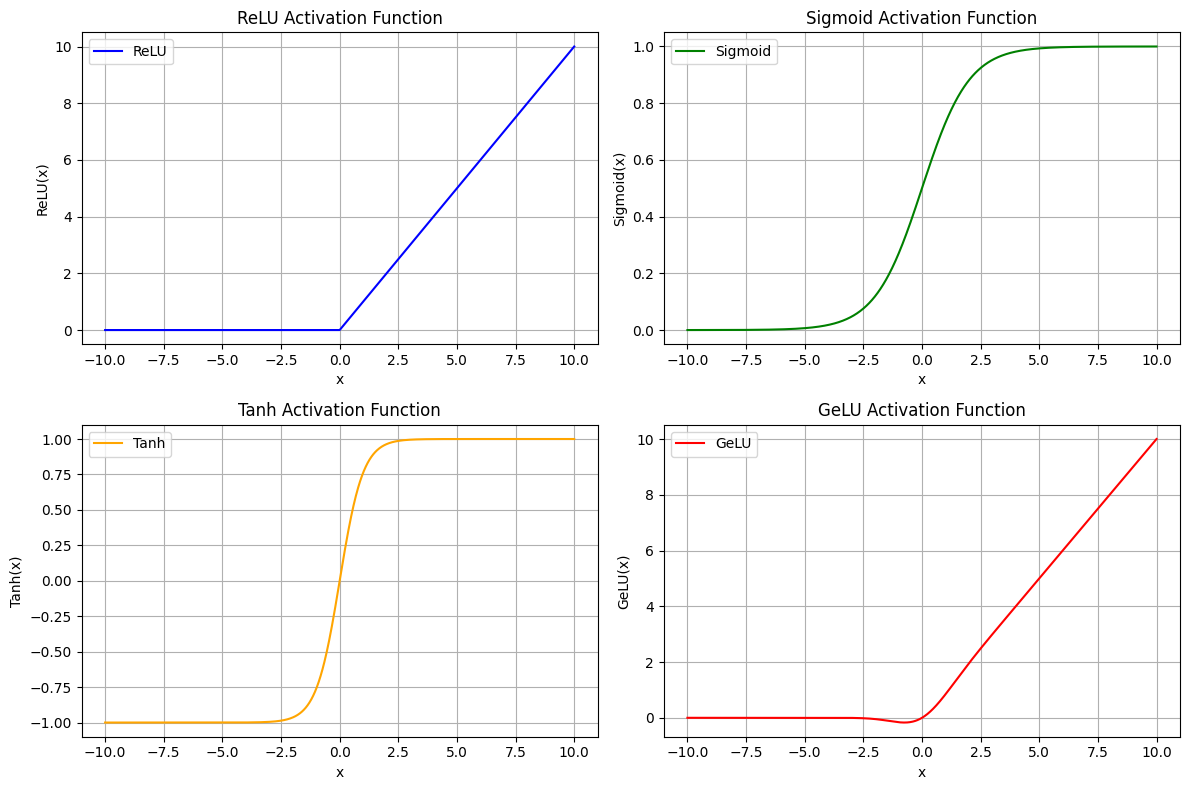

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.special

# Input range
x = np.linspace(-10, 10, 1000)

# Activation functions
relu = np.maximum(0, x)
sigmoid = 1 / (1 + np.exp(-x))
tanh = np.tanh(x)

# GeLU (approximate version)
gelu = 0.5 * x * (1 + np.tanh(np.sqrt(2 / np.pi) * (x + 0.044715 * x**3)))

# Alternatively, use exact GeLU if SciPy is available:
# gelu = x * 0.5 * (1 + scipy.special.erf(x / np.sqrt(2)))

# Plotting
plt.figure(figsize=(12, 8))

# ReLU
plt.subplot(2, 2, 1)
plt.plot(x, relu, label='ReLU', color='blue')
plt.title('ReLU Activation Function')
plt.xlabel('x')
plt.ylabel('ReLU(x)')
plt.grid(True)
plt.legend()

# Sigmoid
plt.subplot(2, 2, 2)
plt.plot(x, sigmoid, label='Sigmoid', color='green')
plt.title('Sigmoid Activation Function')
plt.xlabel('x')
plt.ylabel('Sigmoid(x)')
plt.grid(True)
plt.legend()

# Tanh
plt.subplot(2, 2, 3)
plt.plot(x, tanh, label='Tanh', color='orange')
plt.title('Tanh Activation Function')
plt.xlabel('x')
plt.ylabel('Tanh(x)')
plt.grid(True)
plt.legend()

# GeLU
plt.subplot(2, 2, 4)
plt.plot(x, gelu, label='GeLU', color='red')
plt.title('GeLU Activation Function')
plt.xlabel('x')
plt.ylabel('GeLU(x)')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


0
1/1 [==============================] - 0s 358ms/step
1
1/1 [==============================] - 0s 56ms/step
2
1/1 [==============================] - 0s 45ms/step
3
1/1 [==============================] - 0s 64ms/step
4
1/1 [==============================] - 0s 36ms/step
5
1/1 [==============================] - 0s 43ms/step
6
1/1 [==============================] - 0s 39ms/step
7
1/1 [==============================] - 0s 68ms/step
8
1/1 [==============================] - 0s 34ms/step
9


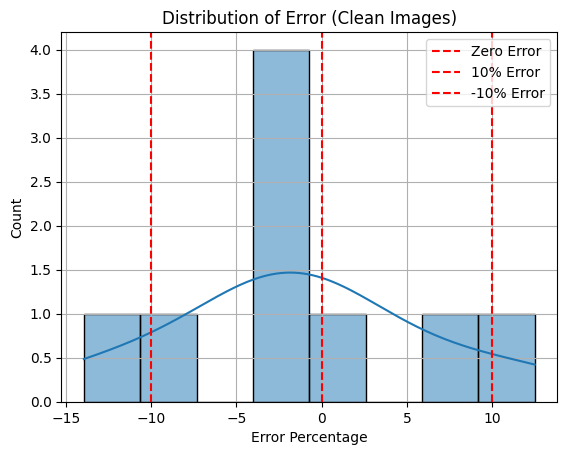

0
1/1 [==============================] - 0s 39ms/step
1
1/1 [==============================] - 0s 55ms/step
2
1/1 [==============================] - 0s 39ms/step
3
1/1 [==============================] - 0s 46ms/step
4
1/1 [==============================] - 0s 40ms/step
5
1/1 [==============================] - 0s 63ms/step
6
1/1 [==============================] - 0s 36ms/step
7
1/1 [==============================] - 0s 85ms/step
8
1/1 [==============================] - 0s 37ms/step
9
1/1 [==============================] - 0s 34ms/step


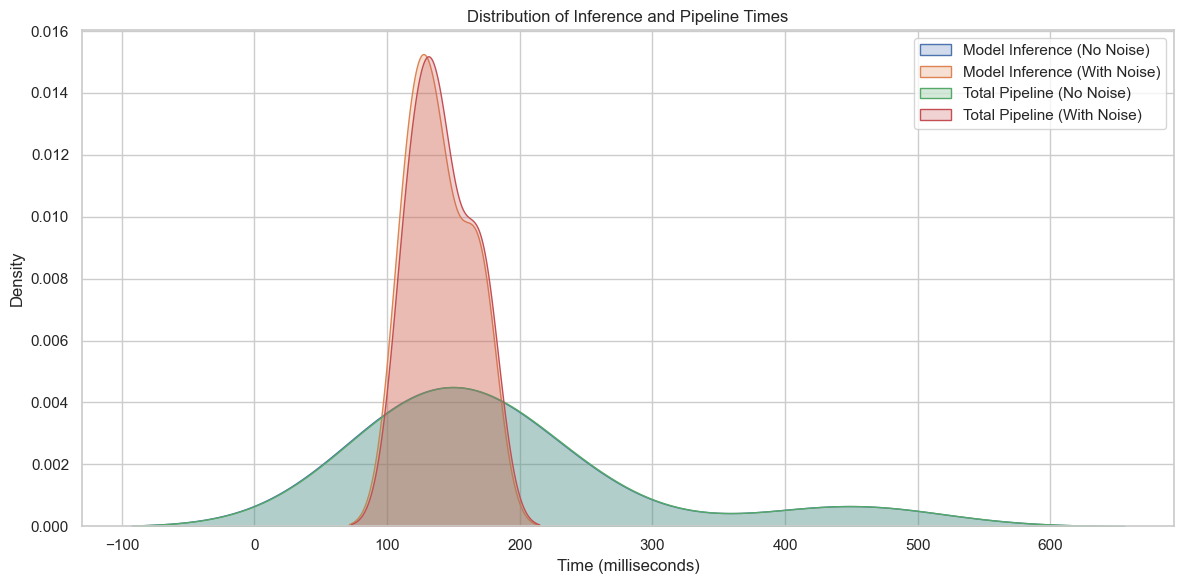

In [ ]:
import os
import numpy as np
import cv2
import time
from tensorflow import keras
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random as ra
from skimage.util import random_noise

# --- Noise modes for the noisy dataset ---
noise_modes = ['s&p', 'pepper', 'salt', 'gaussian']

# --- Preprocess (clean) ---
def preprocess_clean(img_path, img_size):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"Image not found or invalid path: {img_path}")
    img = cv2.resize(img, (img_size[1], img_size[0]))
    img = img / 255.0
    img_array = np.expand_dims(img, axis=-1)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# --- Preprocess (noisy) ---
def preprocess_noisy(img_path, img_size):
    noise_type = ra.randint(0, len(noise_modes) - 1)
    mode = noise_modes[noise_type]

    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"Image not found or invalid path: {img_path}")
    
    img = cv2.resize(img, (img_size[1], img_size[0]))
    img = img.astype(np.float32) / 255.0

    if mode in ['salt', 'pepper', 's&p']:
        img = random_noise(img, mode=mode, amount=0.05)
    elif mode == 'gaussian':
        img = random_noise(img, mode=mode, var=0.001)

    img_array = np.expand_dims(img, axis=-1)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# --- Load model ---
model = keras.models.load_model("BFP02D2s40NT035.h5")

# --- Read labels ---
labels_df = pd.read_csv("cop_img_dataset1/labels.csv")  # expects: filename, fill_percentage

# === Process Clean Images ===
output_rows = []
i=0
for idx, row in labels_df.iterrows():
    print(i)
    i+=1
    if i == 10:
        break
    fname = row["filename"]
    true_fill = float(row["fill_percentage"])
    img_path = os.path.join("cop_img_dataset1", fname)

    try:
        total_start = time.perf_counter()
        img_array = preprocess_clean(img_path, (100, 100))
        model_start = time.perf_counter()
        pred_fill = float(model.predict(img_array)[0][0])
        model_end = time.perf_counter()
        total_end = time.perf_counter()

        model_time = (model_end - model_start) * 1000
        total_time = (total_end - total_start) * 1000
        error_pct = (pred_fill - true_fill) * 100

        output_rows.append({
            "filename": fname,
            "predicted_fill": pred_fill,
            "true_fill": true_fill,
            "error_percentage": error_pct,
            "model_inference_time_ms": model_time,
            "total_pipeline_time_ms": total_time
        })

    except Exception as e:
        continue

pd.DataFrame(output_rows).to_csv("test_acc.csv", index=False)

i=0
# === Process Noisy Images ===
output_rows_noise = []
for idx, row in labels_df.iterrows():
    print(i)
    fname = row["filename"]
    true_fill = float(row["fill_percentage"])
    img_path = os.path.join("cop_img_dataset1", fname)

    try:
        total_start = time.perf_counter()
        img_array = preprocess_noisy(img_path, (100, 100))
        model_start = time.perf_counter()
        pred_fill = float(model.predict(img_array)[0][0])
        model_end = time.perf_counter()
        total_end = time.perf_counter()

        model_time = (model_end - model_start) * 1000
        total_time = (total_end - total_start) * 1000
        error_pct = (pred_fill - true_fill) * 100

        output_rows_noise.append({
            "filename": fname,
            "predicted_fill": pred_fill,
            "true_fill": true_fill,
            "error_percentage": error_pct,
            "model_inference_time_ms": model_time,
            "total_pipeline_time_ms": total_time
        })

    except Exception as e:
        continue
    i+=1
    if i ==10:
        break

pd.DataFrame(output_rows_noise).to_csv("test_acc+n.csv", index=False)

# === Timing Distributions Plot ===
df_clean = pd.read_csv("test_acc.csv")
df_noisy = pd.read_csv("test_acc+n.csv")

plt.figure(figsize=(12, 6))
sns.set(style="whitegrid")

sns.kdeplot(df_clean["model_inference_time_ms"], label="Model Inference (No Noise)", fill=True)
sns.kdeplot(df_noisy["model_inference_time_ms"], label="Model Inference (With Noise)", fill=True)
sns.kdeplot(df_clean["total_pipeline_time_ms"], label="Total Pipeline (No Noise)", fill=True)
sns.kdeplot(df_noisy["total_pipeline_time_ms"], label="Total Pipeline (With Noise)", fill=True)




In [2]:
import os
import csv
import numpy as np
import cv2
import time
from tensorflow import keras
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random as ra
from skimage.util import random_noise

# --- Noise modes for the noisy dataset ---
noise_modes = ['s&p', 'pepper', 'salt', 'gaussian']

# --- Preprocess (clean) ---
def preprocess_clean(img_path, img_size):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"Image not found or invalid path: {img_path}")
    img = cv2.resize(img, (img_size[1], img_size[0]))
    img = img / 255.0
    img_array = np.expand_dims(img, axis=-1)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# --- Preprocess (noisy) ---
def preprocess_noisy(img_path, img_size):
    noise_type = ra.randint(0, len(noise_modes) - 1)
    mode = noise_modes[noise_type]
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"Image not found or invalid path: {img_path}")
    img = cv2.resize(img, (img_size[1], img_size[0]))
    img = img.astype(np.float32) / 255.0
    if mode in ['salt', 'pepper', 's&p']:
        img = random_noise(img, mode=mode, amount=0.05)
    elif mode == 'gaussian':
        img = random_noise(img, mode=mode, var=0.001)
    img_array = np.expand_dims(img, axis=-1)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# --- Load model ---
model = keras.models.load_model("BFP02D2s40NT035.h5")

# --- Read labels ---
labels_df = pd.read_csv("cop_img_dataset1/labels.csv")  # expects: filename, fill_percentage

# === Process Clean Images (All) ===
output_rows = []
for idx, row in labels_df.iterrows():
    fname = row["filename"]
    true_fill = float(row["fill_percentage"])
    img_path = os.path.join("cop_img_dataset1", fname)
    try:
        total_start = time.perf_counter()
        img_array = preprocess_clean(img_path, (100, 100))
        model_start = time.perf_counter()
        pred_fill = float(model.predict(img_array)[0][0])
        model_end = time.perf_counter()
        total_end = time.perf_counter()
        model_time = (model_end - model_start) * 1000
        total_time = (total_end - total_start) * 1000
        error_pct = (pred_fill - true_fill) * 100
        output_rows.append({
            "filename": fname,
            "predicted_fill": pred_fill,
            "true_fill": true_fill,
            "error_percentage": error_pct,
            "model_inference_time_ms": model_time,
            "total_pipeline_time_ms": total_time
        })
    except Exception:
        continue

pd.DataFrame(output_rows).to_csv("test_acc.csv", index=False)



# === Process Noisy Images (Only First 10) ===
output_rows_noise = []
for i, (_, row) in enumerate(labels_df.iterrows()):
    # Limit to first 10 images
    if i >= 10:
        break
    print(i)
    fname = row["filename"]
    true_fill = float(row["fill_percentage"])
    img_path = os.path.join("cop_img_dataset1", fname)
    try:
        total_start = time.perf_counter()
        img_array = preprocess_noisy(img_path, (100, 100))
        model_start = time.perf_counter()
        pred_fill = float(model.predict(img_array)[0][0])
        model_end = time.perf_counter()
        total_end = time.perf_counter()
        model_time = (model_end - model_start) * 1000
        total_time = (total_end - total_start) * 1000
        error_pct = (pred_fill - true_fill) * 100
        output_rows_noise.append({
            "filename": fname,
            "predicted_fill": pred_fill,
            "true_fill": true_fill,
            "error_percentage": error_pct,
            "model_inference_time_ms": model_time,
            "total_pipeline_time_ms": total_time
        })
    except Exception:
        continue

pd.DataFrame(output_rows_noise).to_csv("test_acc+n.csv", index=False)

# === Timing Distributions Plot ===
df_clean = pd.read_csv("test_acc.csv")
df_noisy = pd.read_csv("test_acc+n.csv")

plt.figure(figsize=(12, 6))
sns.set(style="whitegrid")

sns.kdeplot(df_clean["model_inference_time_ms"], label="Model Inference (No Noise)", fill=True)
sns.kdeplot(df_noisy["model_inference_time_ms"], label="Model Inference (With Noise)", fill=True)
sns.kdeplot(df_clean["total_pipeline_time_ms"], label="Total Pipeline (No Noise)", fill=True)
sns.kdeplot(df_noisy["total_pipeline_time_ms"], label="Total Pipeline (With Noise)", fill=True)

plt.title("Distribution of Inference and Pipeline Times")
plt.xlabel("Time (milliseconds)")
plt.ylabel("Density")
plt.legend(loc="upper right")
plt.grid(True)
plt.tight_layout()
plt.show()


1/1 [==============================] - 0s 37ms/step


KeyboardInterrupt: 

In [9]:
import os
import numpy as np
import cv2
import time
from tensorflow import keras
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random as ra
from skimage.util import random_noise

# --- Noise modes for the noisy dataset ---
noise_modes = ['s&p', 'pepper', 'salt', 'gaussian']

# --- Preprocess (clean) ---
def preprocess_clean(img_path, img_size):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"Image not found or invalid path: {img_path}")
    img = cv2.resize(img, (img_size[1], img_size[0]))
    img = img / 255.0
    img_array = np.expand_dims(img, axis=-1)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# --- Preprocess (noisy) ---
def preprocess_noisy(img_path, img_size):
    noise_type = ra.randint(0, len(noise_modes) - 1)
    mode = noise_modes[noise_type]

    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"Image not found or invalid path: {img_path}")
    
    img = cv2.resize(img, (img_size[1], img_size[0]))
    img = img.astype(np.float32) / 255.0

    if mode in ['salt', 'pepper', 's&p']:
        img = random_noise(img, mode=mode, amount=0.05)
    elif mode == 'gaussian':
        img = random_noise(img, mode=mode, var=0.001)

    img_array = np.expand_dims(img, axis=-1)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# --- Load model ---
model = keras.models.load_model("BFP02D2x4s40N2T035.h5")

# --- Read labels ---
labels_df = pd.read_csv("cop_img_dataset1/labels.csv")  # expects: filename, fill_percentage
stap = 100  # Limit to first 10 images for testing
# === Process Clean Images ===
output_rows = []
i = 0
for idx, row in labels_df.iterrows():


    fname = row["filename"]
    true_fill = float(row["fill_percentage"])
    img_path = os.path.join("cop_img_dataset1", fname)

    try:
        total_start = time.perf_counter()
        img_array = preprocess_clean(img_path, (100, 100))
        model_start = time.perf_counter()
        pred_fill = float(model.predict(img_array)[0][0])
        model_end = time.perf_counter()
        total_end = time.perf_counter()

        model_time = (model_end - model_start) * 1000
        total_time = (total_end - total_start) * 1000
        error_pct =  (pred_fill - true_fill) * 100

        output_rows.append({
            "filename": fname,
            "predicted_fill": pred_fill,
            "true_fill": true_fill,
            "error_percentage": error_pct,
            "model_inference_time_ms": model_time,
            "total_pipeline_time_ms": total_time
        })

    except Exception as e:
        continue

pd.DataFrame(output_rows).to_csv("test_acc.csv", index=False)

# === Process Noisy Images ===
output_rows_noise = []
i = 0
for idx, row in labels_df.iterrows():
    print(i)
    fname = row["filename"]
    true_fill = float(row["fill_percentage"])
    img_path = os.path.join("cop_img_dataset1", fname)

    try:
        total_start = time.perf_counter()
        img_array = preprocess_noisy(img_path, (100, 100))
        model_start = time.perf_counter()
        pred_fill = float(model.predict(img_array)[0][0])
        model_end = time.perf_counter()
        total_end = time.perf_counter()

        model_time = (model_end - model_start) * 1000
        total_time = (total_end - total_start) * 1000
        error_pct = abs((pred_fill - true_fill) * 100)

        output_rows_noise.append({
            "filename": fname,
            "predicted_fill": pred_fill,
            "true_fill": true_fill,
            "error_percentage": error_pct,
            "model_inference_time_ms": model_time,
            "total_pipeline_time_ms": total_time
        })

    except Exception as e:
        continue
    i += 1


pd.DataFrame(output_rows_noise).to_csv("test_acc+n.csv", index=False)

# === Timing Distributions Plot ===
df_clean = pd.read_csv("test_acc.csv")
df_noisy = pd.read_csv("test_acc+n.csv")



# === New Function: Plot Each Timing Distribution Separately ===
def plot_timing_distributions_separately(df_clean, df_noisy):
    """Plot KDEs separately for each timing metric."""

    sns.set(style="whitegrid")

    # 1. Model Inference Time - No Noise
    plt.figure(figsize=(6,4))
    sns.histplot(df_clean["model_inference_time_ms"], fill=True, color='b',kde=True,shrink=0.1)

    plt.title("Model Inference Time (No Noise)")
    plt.xlabel("Time (ms)")
    plt.ylabel("Density")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # 2. Model Inference Time - With Noise
    plt.figure(figsize=(6,4))
    sns.histplot(df_noisy["model_inference_time_ms"], fill=True, color='r',kde=True,shrink=0.1)
    plt.title("Model Inference Time (With Noise)")
    plt.xlabel("Time (ms)")
    plt.ylabel("Density")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # 3. Total Pipeline Time - No Noise
    plt.figure(figsize=(6,4))
    sns.histplot(df_clean["total_pipeline_time_ms"], fill=True, color='g',kde=True,shrink=0.1)
    plt.title("Total Pipeline Time (No Noise)")
    plt.xlabel("Time (ms)")
    plt.ylabel("Density")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # 4. Total Pipeline Time - With Noise
    plt.figure(figsize=(6,4))
    sns.histplot(df_noisy["total_pipeline_time_ms"], fill=True, color='orange',kde=True,shrink=0.1)
    plt.title("Total Pipeline Time (With Noise)")
    plt.xlabel("Time (ms)")
    plt.ylabel("Density")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# === Call the new plotting function ===
plot_timing_distributions_separately(df_clean, df_noisy)


1/1 [==============================] - 0s 45ms/step


KeyboardInterrupt: 

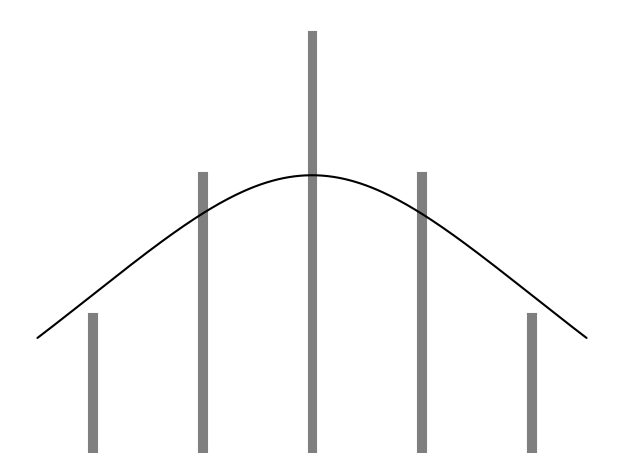

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# Example data
data = [1, 2, 2, 3, 3, 3, 4, 4, 5]

# Minimalist histplot
sns.histplot(data, shrink=0.1, kde=True, color='black')

# Remove all "decoration"
plt.gca().set_title("")
plt.gca().set_xlabel("")
plt.gca().set_ylabel("")
plt.gca().legend_.remove() if plt.gca().legend_ else None
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.xticks([])
plt.yticks([])
plt.grid(False)

plt.tight_layout()
plt.show()


1/1 [==============================] - 0s 69ms/step


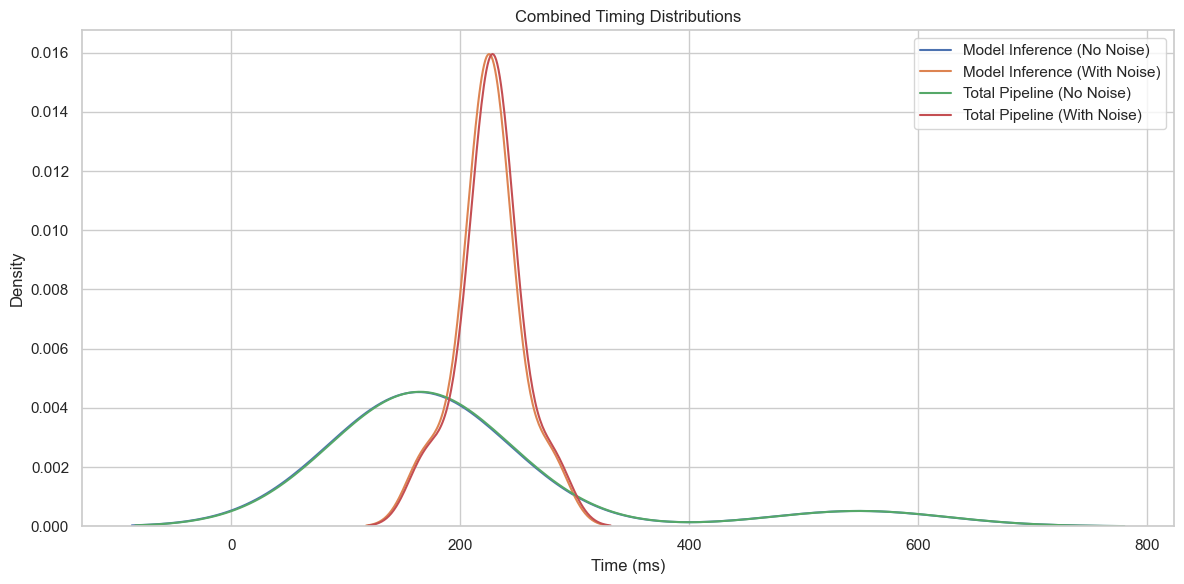

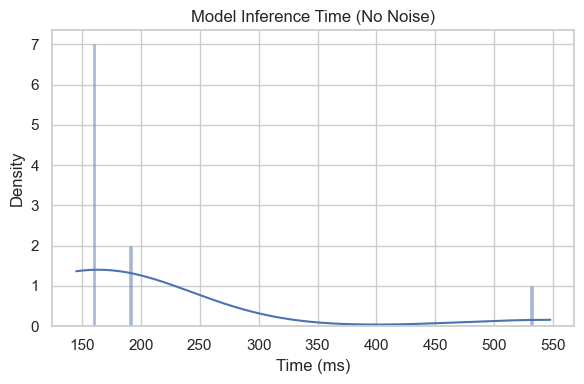

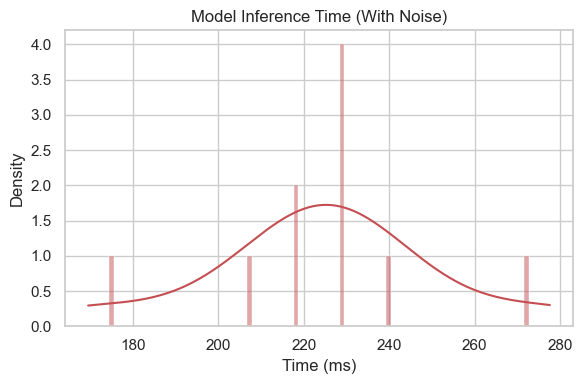

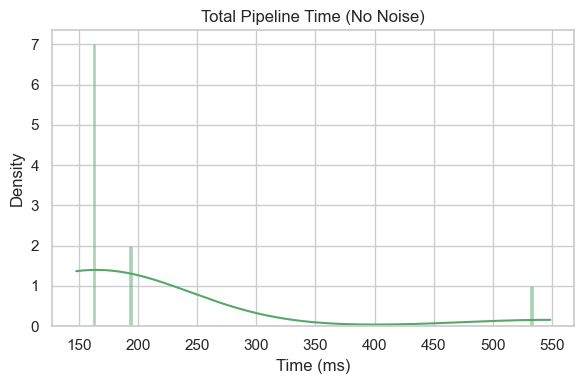

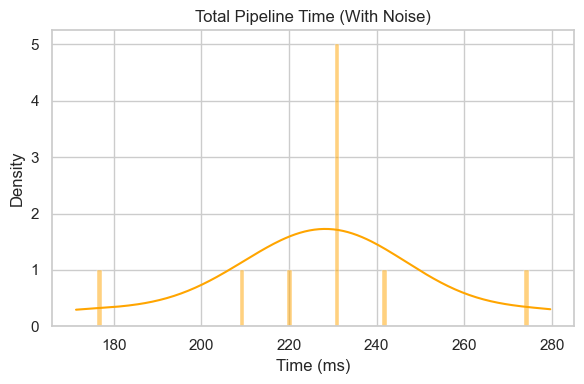

In [ ]:
import os
import numpy as np
import cv2
import time
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random as ra
from tensorflow import keras
from skimage.util import random_noise

# --- Global Settings ---
noise_modes = ['s&p', 'pepper', 'salt', 'gaussian']
IMAGE_SIZE = (100, 100)
MODEL_PATH = "BFP02D2s40NT035.h5"
LABELS_PATH = "cop_img_dataset1/labels.csv"
CLEAN_CSV = "test_acc.csv"
NOISY_CSV = "test_acc+n.csv"
DATASET_PATH = "cop_img_dataset1"
TEST_LIMIT = 10  # Number of images to process

# --- Preprocessing Functions ---
def preprocess_clean(img_path, img_size):
    """Preprocess image without noise."""
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"Invalid image path: {img_path}")
    img = cv2.resize(img, (img_size[1], img_size[0])) / 255.0
    return np.expand_dims(np.expand_dims(img, axis=-1), axis=0)

def preprocess_noisy(img_path, img_size):
    """Preprocess image with random noise added."""
    mode = noise_modes[ra.randint(0, len(noise_modes) - 1)]
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"Invalid image path: {img_path}")
    img = cv2.resize(img, (img_size[1], img_size[0])).astype(np.float32) / 255.0
    if mode in ['salt', 'pepper', 's&p']:
        img = random_noise(img, mode=mode, amount=0.05)
    elif mode == 'gaussian':
        img = random_noise(img, mode=mode, var=0.001)
    return np.expand_dims(np.expand_dims(img, axis=-1), axis=0)

# --- Load Model and Labels ---
model = keras.models.load_model(MODEL_PATH)
labels_df = pd.read_csv(LABELS_PATH)  # columns: filename, fill_percentage

# --- Process Clean Images ---
output_clean = []
for i, (_, row) in enumerate(labels_df.iterrows()):
    if i >= TEST_LIMIT:
        break
    fname = row["filename"]
    true_fill = float(row["fill_percentage"])
    img_path = os.path.join(DATASET_PATH, fname)

    try:
        total_start = time.perf_counter()
        img_array = preprocess_clean(img_path, IMAGE_SIZE)
        model_start = time.perf_counter()
        pred_fill = float(model.predict(img_array)[0][0])
        model_end = time.perf_counter()
        total_end = time.perf_counter()

        output_clean.append({
            "filename": fname,
            "predicted_fill": pred_fill,
            "true_fill": true_fill,
            "error_percentage": abs((pred_fill - true_fill) * 100),
            "model_inference_time_ms": (model_end - model_start) * 1000,
            "total_pipeline_time_ms": (total_end - total_start) * 1000
        })
    except Exception as e:
        print(f"Error processing {fname}: {e}")

pd.DataFrame(output_clean).to_csv(CLEAN_CSV, index=False)

# --- Process Noisy Images ---
output_noisy = []
for i, (_, row) in enumerate(labels_df.iterrows()):
    if i >= TEST_LIMIT:
        break
    fname = row["filename"]
    true_fill = float(row["fill_percentage"])
    img_path = os.path.join(DATASET_PATH, fname)

    try:
        total_start = time.perf_counter()
        img_array = preprocess_noisy(img_path, IMAGE_SIZE)
        model_start = time.perf_counter()
        pred_fill = float(model.predict(img_array)[0][0])
        model_end = time.perf_counter()
        total_end = time.perf_counter()

        output_noisy.append({
            "filename": fname,
            "predicted_fill": pred_fill,
            "true_fill": true_fill,
            "error_percentage": abs((pred_fill - true_fill) * 100),
            "model_inference_time_ms": (model_end - model_start) * 1000,
            "total_pipeline_time_ms": (total_end - total_start) * 1000
        })
    except Exception as e:
        print(f"Error processing {fname}: {e}")

pd.DataFrame(output_noisy).to_csv(NOISY_CSV, index=False)

# --- Load Results ---
df_clean = pd.read_csv(CLEAN_CSV)
df_noisy = pd.read_csv(NOISY_CSV)


plt.figure(figsize=(12, 6))


sns.kdeplot(df_clean["model_inference_time_ms"], label="Model Inference (No Noise)")
sns.kdeplot(df_noisy["model_inference_time_ms"], label="Model Inference (With Noise)")
sns.kdeplot(df_clean["total_pipeline_time_ms"], label="Total Pipeline (No Noise)")
sns.kdeplot(df_noisy["total_pipeline_time_ms"], label="Total Pipeline (With Noise)")


# --- Function: Plot Timing Distributions Separately ---
def plot_timing_distributions_separately(df_clean, df_noisy):
    """Plot KDEs separately for each timing metric."""
    sns.set(style="whitegrid")
    metrics = [
        ("model_inference_time_ms", df_clean, "Model Inference Time (No Noise)", 'b'),
        ("model_inference_time_ms", df_noisy, "Model Inference Time (With Noise)", 'r'),
        ("total_pipeline_time_ms", df_clean, "Total Pipeline Time (No Noise)", 'g'),
        ("total_pipeline_time_ms", df_noisy, "Total Pipeline Time (With Noise)", 'orange'),
    ]

    for metric, df, title, color in metrics:
        plt.figure(figsize=(6, 4))
        sns.histplot(df[metric], fill=True, color=color, kde=True, shrink=0.1)
        plt.title(title)
        plt.xlabel("Time (ms)")
        plt.ylabel("Density")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

# --- Plot Separate Timing Distributions ---
plot_timing_distributions_separately(df_clean, df_noisy)


In [ ]:
import re

# Input text (can be from a file or another source)
log_text = """
1/1 [==============================] - 0s 201ms/step 
1/1 [==============================] - 0s 151ms/step
1/1 [==============================] - 0s 136ms/step
1/1 [==============================] - 0s 33ms/step
1/1 [==============================] - 0s 33ms/step
1/1 [==============================] - 0s 34ms/step
1/1 [==============================] - 0s 34ms/step
1/1 [==============================] - 0s 35ms/step
1/1 [==============================] - 0s 38ms/step
1/1 [==============================] - 0s 35ms/step
1/1 [==============================] - 0s 37ms/step
1/1 [==============================] - 0s 35ms/step
1/1 [==============================] - 0s 32ms/step
1/1 [==============================] - 0s 34ms/step
1/1 [==============================] - 0s 35ms/step
1/1 [==============================] - 0s 59ms/step
1/1 [==============================] - 0s 45ms/step
1/1 [==============================] - 0s 34ms/step
1/1 [==============================] - 0s 34ms/step
1/1 [==============================] - 0s 44ms/step
1/1 [==============================] - 0s 46ms/step
1/1 [==============================] - 0s 34ms/step
1/1 [==============================] - 0s 34ms/step
1/1 [==============================] - 0s 34ms/step
1/1 [==============================] - 0s 98ms/step
"""

# Extract all the numbers followed by "ms"
matches = re.findall(r'(\d+)ms', log_text)

# Convert to integers if needed
ms_values = list(map(int, matches))

# Print the results
print(ms_values)


In [7]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error , r2_score

# Load CSV file
data = pd.read_csv('test_acc+n.csv')  

# Extract predicted and true values
y_pred = data['predicted_fill']
y_true = data['true_fill']

# Compute MAE
mae = mean_absolute_error(y_true, y_pred)
# RMSE Calculation
rmse = np.sqrt(mae)
r2 = r2_score(y_true, y_pred)
print(f"R^2: {r2}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")


R^2: 0.9652838231518865
Root Mean Squared Error (RMSE): 0.1879949633762333
Mean Absolute Error (MAE): 0.03534210625483131
